In [1]:
from os import getcwd
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [36]:
vae_dir = join(getcwd(), "vae") 
vae_small_dir = join(getcwd(), "vae_small") 

vae_data_dir = join(vae_dir, "data")
vae_small_dir_data = join(vae_small_dir, "data")

vae_img_dir = join(vae_dir, "img")
vae_small_dir_img = join(vae_small_dir, "img")

# Path to be adapted to each user
vnca_test_dir = join("/Users/user/Desktop/Msc AI RU/natural_computing/final/", "vnca", "loss_data", "test")
vnca_train_dir = join("/Users/user/Desktop/Msc AI RU/natural_computing/final/", "vnca", "loss_data", "train")

# Process Training Data VAE

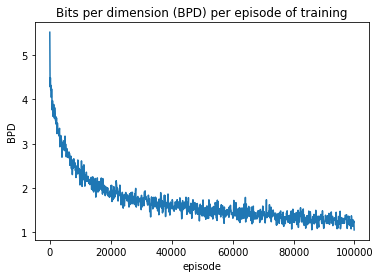

In [37]:
# Plot bits per dimension over training
bpd_train = np.genfromtxt(join(vae_data_dir, "train", "bpd-loss.csv"), skip_header=1, delimiter=",")
plt.plot(bpd_train[:,1], bpd_train[:,2])
plt.title("Bits per dimension (BPD) per episode of training")
plt.ylabel("BPD")
plt.xlabel("episode")
plt.savefig(join(vae_img_dir, "train", "bpd_plot.png") )
plt.show()

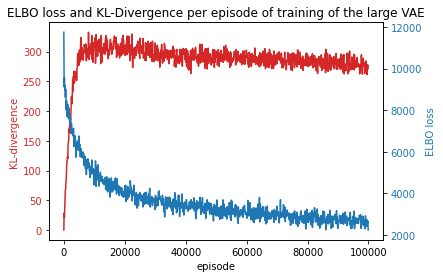

In [38]:
# Plot the combined ELBO loss and KL divergence of the large VAE model during training
elbo_train = np.genfromtxt(join(vae_data_dir, "train", "total-loss.csv"), skip_header=1, delimiter=",")
kl_train = np.genfromtxt(join(vae_data_dir, "train", "kl-loss.csv"), skip_header=1, delimiter=",")

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(kl_train[:,1], kl_train[:,2], color=color)
ax1.set_ylabel("KL-divergence", color=color)
ax1.set_xlabel("episode")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel("ELBO loss", color=color) 
ax2.plot(elbo_train[:,1], elbo_train[:,2], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_title("ELBO loss and KL-Divergence per episode of training of the large VAE")
plt.savefig(join(vae_img_dir, "elbo_kl_plot_vae.png"))
plt.show()

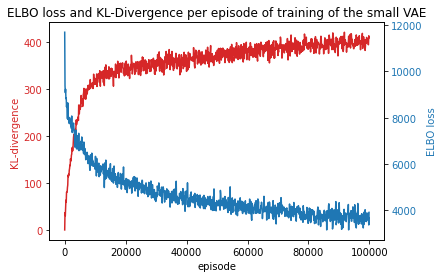

In [39]:
# Plot the combined ELBO loss and KL divergence of the small VAE model during training
elbo_train_small = np.genfromtxt(join(vae_small_dir_data, "train", "total-loss.csv"), skip_header=1, delimiter=",")
kl_train_small = np.genfromtxt(join(vae_small_dir_data, "train", "kl-loss.csv"), skip_header=1, delimiter=",")

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(kl_train_small[:,1], kl_train_small[:,2], color=color)
ax1.set_ylabel("KL-divergence", color=color)
ax1.set_xlabel("episode")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel("ELBO loss", color=color) 
ax2.plot(elbo_train_small[:,1], elbo_train_small[:,2], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_title("ELBO loss and KL-Divergence per episode of training of the small VAE")
plt.savefig(join(vae_small_dir_img, "elbo_kl_plot_small.png"))
plt.show()

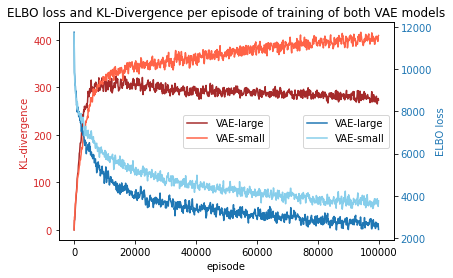

In [40]:
# Plot the combined ELBO loss and KL divergence of the large and small VAE model together during training
elbo_train = np.genfromtxt(join(vae_data_dir, "train", "total-loss.csv"), skip_header=1, delimiter=",")
kl_train = np.genfromtxt(join(vae_data_dir, "train", "kl-loss.csv"), skip_header=1, delimiter=",")
elbo_train_small = np.genfromtxt(join(vae_small_dir_data, "train", "total-loss.csv"), skip_header=1, delimiter=",")
kl_train_small = np.genfromtxt(join(vae_small_dir_data, "train", "kl-loss.csv"), skip_header=1, delimiter=",")

elbo_train_vals = pd.DataFrame({"data": elbo_train[:,2]})
kl_train_vals = pd.DataFrame({"data": kl_train[:,2]})
elbo_train_small_vals = pd.DataFrame({"data": elbo_train_small[:,2]})
kl_train_small_vals = pd.DataFrame({"data": kl_train_small[:,2]})

ema = elbo_train_vals.ewm(com=0.6).mean()
ema2 = kl_train_vals.ewm(com=0.6).mean()
ema3 = elbo_train_small_vals.ewm(com=0.6).mean()
ema4 = kl_train_small_vals.ewm(com=0.6).mean()

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(kl_train[:,1], ema2, color="brown", label="VAE-large")
ax1.plot(kl_train_small[:,1], ema4, color="tomato", label="VAE-small")
ax1.set_ylabel("KL-divergence", color=color)
ax1.set_xlabel("episode")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc="center")

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel("ELBO loss", color=color) 
ax2.plot(elbo_train[:,1], ema, color=color, label="VAE-large")
ax2.plot(elbo_train_small[:,1], ema3, color="skyblue", label="VAE-small")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc="center right")

ax1.set_title("ELBO loss and KL-Divergence per episode of training of both VAE models")
plt.savefig(join(vae_small_dir_img, "elbo_kl_plot_vaes.png"))
plt.show()

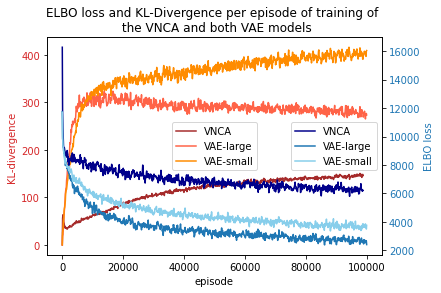

In [41]:
# Plot the combined ELBO loss and KL divergence of the VNCA and both VAE models together during training
elbo_train = np.genfromtxt(join(vae_data_dir, "train", "total-loss.csv"), skip_header=1, delimiter=",")
kl_train = np.genfromtxt(join(vae_data_dir, "train", "kl-loss.csv"), skip_header=1, delimiter=",")
elbo_train_small = np.genfromtxt(join(vae_small_dir_data, "train", "total-loss.csv"), skip_header=1, delimiter=",")
kl_train_small = np.genfromtxt(join(vae_small_dir_data, "train", "kl-loss.csv"), skip_header=1, delimiter=",")
elbo_vnca = np.genfromtxt(join(vnca_train_dir, "run-.-tag-loss.csv"), skip_header=1, delimiter=",")
kl_vnca = np.genfromtxt(join(vnca_train_dir, "run-.-tag-kl_loss.csv"), skip_header=1, delimiter=",")

elbo_train_vals = pd.DataFrame({"data": elbo_train[:,2]})
kl_train_vals = pd.DataFrame({"data": kl_train[:,2]})
elbo_train_small_vals = pd.DataFrame({"data": elbo_train_small[:,2]})
kl_train_small_vals = pd.DataFrame({"data": kl_train_small[:,2]})
elbo_vnca_vals = pd.DataFrame({"data": elbo_vnca[:,2]})
kl_vnca_vals = pd.DataFrame({"data": kl_vnca[:,2]})

ema = elbo_train_vals.ewm(com=0.6).mean()
ema2 = kl_train_vals.ewm(com=0.6).mean()
ema3 = elbo_train_small_vals.ewm(com=0.6).mean()
ema4 = kl_train_small_vals.ewm(com=0.6).mean()
ema5 = elbo_vnca_vals.ewm(com=0.6).mean()
ema6 = kl_vnca_vals.ewm(com=0.6).mean()

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(kl_vnca[:,1], ema6, color="brown", label="VNCA")
ax1.plot(kl_train[:,1], ema2, color="tomato", label="VAE-large")
ax1.plot(kl_train_small[:,1], ema4, color="darkorange", label="VAE-small")
ax1.set_ylabel("KL-divergence", color=color)
ax1.set_xlabel("episode")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc="center")

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel("ELBO loss", color=color) 
ax2.plot(elbo_vnca[:,1], ema5, color="darkblue", label="VNCA")
ax2.plot(elbo_train[:,1], ema, color=color, label="VAE-large")
ax2.plot(elbo_train_small[:,1], ema3, color="skyblue", label="VAE-small")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc="center right")

ax1.set_title("ELBO loss and KL-Divergence per episode of training of \n the VNCA and both VAE models")
plt.savefig(join(vae_small_dir_img, "elbo_kl_plot_all.png"))
plt.show()

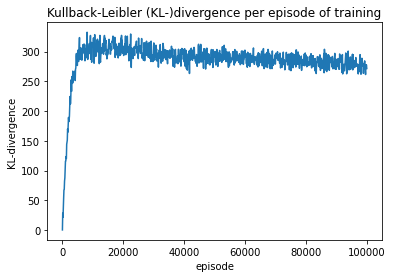

In [42]:
# Plot KL-Divergence over training
kl_train = np.genfromtxt(join(vae_data_dir, "train", "kl-loss.csv"), skip_header=1, delimiter=",")
plt.plot(kl_train[:,1], kl_train[:,2])
plt.title("Kullback-Leibler (KL-)divergence per episode of training")
plt.ylabel("KL-divergence")
plt.xlabel("episode")
plt.savefig(join(vae_img_dir, "train", "kl_plot.png") )
plt.show()

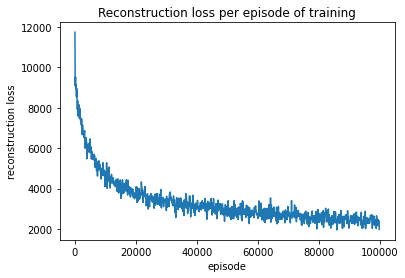

In [43]:
# Plot Reconstruction loss over training
recon_train = np.genfromtxt(join(vae_data_dir, "train", "recon-loss.csv"), skip_header=1, delimiter=",")
plt.plot(recon_train[:,1], recon_train[:,2])
plt.title("Reconstruction loss per episode of training")
plt.ylabel("reconstruction loss")
plt.xlabel("episode")
plt.savefig(join(vae_img_dir, "train", "recon_plot.png") )
plt.show()

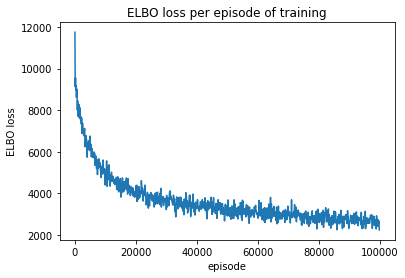

In [44]:
# Plot total ELBO loss over training
elbo_train = np.genfromtxt(join(vae_data_dir, "train", "total-loss.csv"), skip_header=1, delimiter=",")
plt.plot(elbo_train[:,1], elbo_train[:,2])
plt.title("ELBO loss per episode of training")
plt.ylabel("ELBO loss")
plt.xlabel("episode")
plt.savefig(join(vae_img_dir, "train", "elbo_plot.png") )
plt.show()

# Process validation data for VAE 

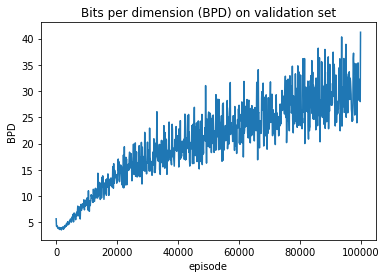

In [45]:
# Plot bits per dimension over training
bpd_test = np.genfromtxt(join(vae_data_dir, "test", "bpd-loss.csv"), skip_header=1, delimiter=",")
plt.plot(bpd_test[:,1], bpd_test[:,2])
plt.title("Bits per dimension (BPD) on validation set")
plt.ylabel("BPD")
plt.xlabel("episode")
plt.savefig(join(vae_img_dir, "test", "bpd_plot.png") )
plt.show()

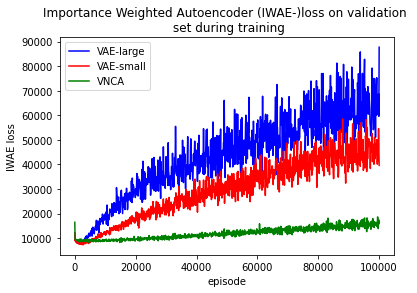

In [55]:
# Plot IWAE loss on validation set over training time for all three models (VNCA, small VAE and large VAE)
iwae_test_small = np.genfromtxt(join(vae_small_dir_data, "test", "total-loss.csv"), skip_header=1, delimiter=",")
iwae_test = np.genfromtxt(join(vae_data_dir, "test", "total-loss.csv"), skip_header=1, delimiter=",")
iwae_loss_val = np.genfromtxt(join(vnca_test_dir, "total-loss.csv"), skip_header=1, delimiter=",")

plt.ylabel("IWAE loss")
plt.plot(iwae_test[:,1], iwae_test[:,2], color="blue", label="VAE-large")
plt.plot(iwae_test_small[:,1], iwae_test_small[:,2], color="red", label="VAE-small")
plt.plot(iwae_loss_val[:,1], iwae_loss_val[:,2], color="green", label="VNCA")
plt.title("Importance Weighted Autoencoder (IWAE-)loss on validation \n set during training")
plt.xlabel("episode")
plt.legend(loc="best")
plt.savefig(join(vae_small_dir_img, "test", "iwae_plot_all.png") )
plt.show()

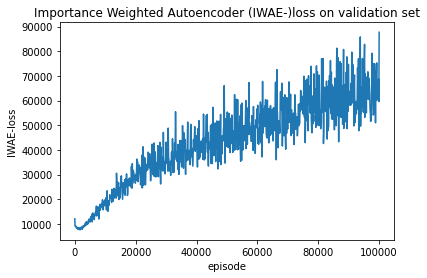

In [47]:
# Plot IWAE loss on validation set over training
iwae_test = np.genfromtxt(join(vae_data_dir, "test", "total-loss.csv"), skip_header=1, delimiter=",")
plt.plot(iwae_test[:,1], iwae_test[:,2])
plt.title("Importance Weighted Autoencoder (IWAE-)loss on validation set")
plt.ylabel("IWAE-loss")
plt.xlabel("episode")
plt.savefig(join(vae_img_dir, "test", "iwae_plot.png") )
plt.show()

# Process training data VAE Small

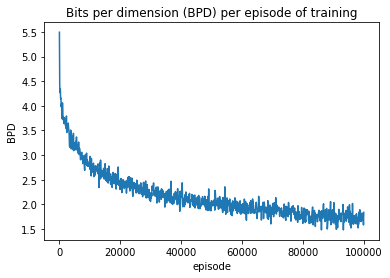

In [48]:
# Plot bits per dimension over training
bpd_train_small = np.genfromtxt(join(vae_small_dir_data, "train", "bpd-loss.csv"), skip_header=1, delimiter=",")
plt.plot(bpd_train_small[:,1], bpd_train_small[:,2])
plt.title("Bits per dimension (BPD) per episode of training")
plt.ylabel("BPD")
plt.xlabel("episode")
plt.savefig(join(vae_small_dir_img, "train", "bpd_plot.png") )
plt.show()

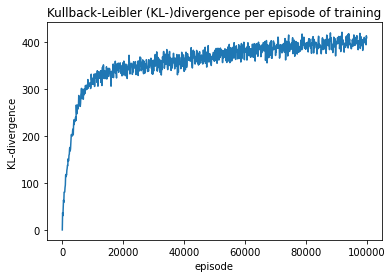

In [49]:
# Plot KL-divergence over training
kl_train_small = np.genfromtxt(join(vae_small_dir_data, "train", "kl-loss.csv"), skip_header=1, delimiter=",")
plt.plot(kl_train_small[:,1], kl_train_small[:,2])
plt.title("Kullback-Leibler (KL-)divergence per episode of training")
plt.ylabel("KL-divergence")
plt.xlabel("episode")
plt.savefig(join(vae_small_dir_img, "train", "kl_plot.png") )
plt.show()

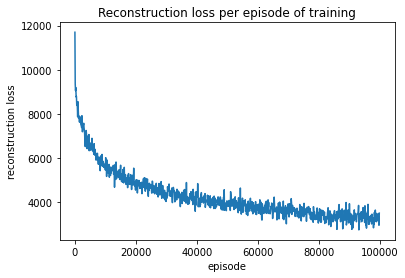

In [50]:
# Plot Reconstruction Loss over training
recon_train_small = np.genfromtxt(join(vae_small_dir_data, "train", "recon-loss.csv"), skip_header=1, delimiter=",")
plt.plot(recon_train_small[:,1], recon_train_small[:,2])
plt.title("Reconstruction loss per episode of training")
plt.ylabel("reconstruction loss")
plt.xlabel("episode")
plt.savefig(join(vae_small_dir_img, "train", "recon_plot.png") )
plt.show()

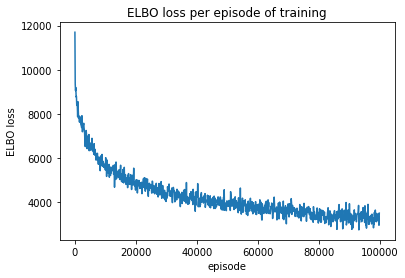

In [51]:
# Plot ELBO Loss over training
elbo_train_small = np.genfromtxt(join(vae_small_dir_data, "train", "total-loss.csv"), skip_header=1, delimiter=",")
plt.plot(recon_train_small[:,1], recon_train_small[:,2])
plt.title("ELBO loss per episode of training")
plt.ylabel("ELBO loss")
plt.xlabel("episode")
plt.savefig(join(vae_small_dir_img, "train", "elbo_plot.png") )
plt.show()

# Plot validation data for VAE-Small

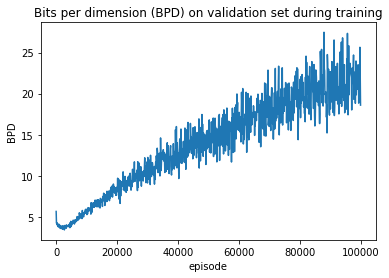

In [52]:
# Plot bits per dimension on validation set over training
bpd_test_small = np.genfromtxt(join(vae_small_dir_data, "test", "bpd-loss.csv"), skip_header=1, delimiter=",")
plt.plot(bpd_test_small[:,1], bpd_test_small[:,2])
plt.title("Bits per dimension (BPD) on validation set during training")
plt.ylabel("BPD")
plt.xlabel("episode")
plt.savefig(join(vae_small_dir_img, "test", "bpd_plot.png") )
plt.show()

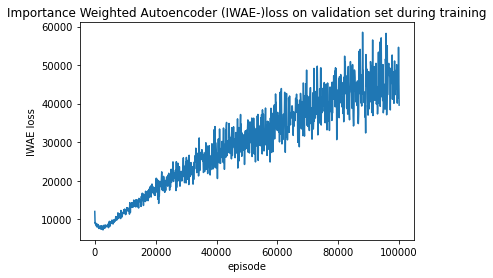

In [53]:
# Plot IWAE loss on validation set over training time
iwae_test_small = np.genfromtxt(join(vae_small_dir_data, "test", "total-loss.csv"), skip_header=1, delimiter=",")
plt.plot(iwae_test_small[:,1], iwae_test_small[:,2])
plt.title("Importance Weighted Autoencoder (IWAE-)loss on validation set during training")
plt.ylabel("IWAE loss")
plt.xlabel("episode")
plt.savefig(join(vae_small_dir_img, "test", "iwae_plot.png") )
plt.show()

In [2]:
import torch as t
import math
from torch import nn
from torch.nn import DataParallel
from torchvision import transforms, datasets

from distributions import DiscretizedMixtureLogitsDistribution
from vae import VAE
from vae_small import VAE_SMALL
from train import train
from data import PokemonIMG
from loss import elbo

c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
z_size = 256
vae_hid = 128
n_mixtures = 1
batch_size = 32
dmg_size = 16
p_update = 1.0
min_steps, max_steps = 64, 128

encoder_hid = 32
h = w = 32
n_channels = 3

In [4]:
n_mixtures = 1

# input 'state' should have as shape (batch_size, z_space, height, width)
def state_to_dist(state):
    return DiscretizedMixtureLogitsDistribution(n_mixtures, state[:, :n_mixtures * 10, :, :])

In [5]:
dset = PokemonIMG()

num_samples = len(dset)
train_split = 0.7
val_split = 0.2
test_split = 0.1

num_train = math.floor(num_samples*train_split)
num_val = math.floor(num_samples*val_split)
num_test = math.floor(num_samples*test_split)
num_test = num_test + (num_samples - num_train - num_val - num_test)

train_set, val_set, test_set = t.utils.data.random_split(dset, [num_train, num_val, num_test])

In [5]:
vae = VAE(h, w, n_channels, z_size, train_set, val_set, test_set, state_to_dist, batch_size, p_update, min_steps, max_steps, encoder_hid)

VAE(
  (conv2d1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2d2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2d3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2d4): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2d5): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (elu): ELU(alpha=1.0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=2048, out_features=512, bias=True)
  (dec_lin): Linear(in_features=256, out_features=4096, bias=True)
  (conv_t2d1): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (conv_t2d2): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (conv_t2d3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (conv_t2d4): ConvTranspose2d(128, 64, kernel_

In [9]:
param_path = join(getcwd(), "latest_VAE")

In [10]:
vae.load(param_path)

In [ ]:
vae.test(128)

In [6]:
vae_small = VAE_SMALL(h, w, n_channels, z_size, train_set, val_set, test_set, state_to_dist, batch_size, encoder_hid)

VAE_SMALL(
  (conv2d1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2d2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2d3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2d4): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (elu): ELU(alpha=1.0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=4096, out_features=512, bias=True)
  (dec_lin): Linear(in_features=256, out_features=2048, bias=True)
  (conv_t2d1): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (conv_t2d2): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (conv_t2d3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (conv_t2d4): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (conv_t2d

In [8]:
param_path = join(getcwd(), "latest_VAE_SMALL")
vae_small.load(param_path)

In [ ]:
vae_small.test(128)

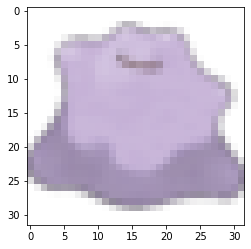

In [ ]:
plt.imshow(dset.find("132.png")[0].permute(1, 2, 0))

In [ ]:
test_img = dset.find("132.png")[0]
print(test_img.shape)
test_img = test_img.unsqueeze(0)
print(test_img.shape)

torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])


In [ ]:
loss, z, p_x_given_z, recon_loss, kl_loss, states = vnca.forward(test_img, 1, elbo)

shape of z torch.Size([1, 1, 256])
reshape 1: torch.Size([1, 256])
reshape 2: torch.Size([1, 256, 1])
reshape 3: torch.Size([1, 256, 1, 1])
reshape 4: torch.Size([1, 256, 32, 32])
shape of the state to propagate torch.Size([1, 256, 32, 32])


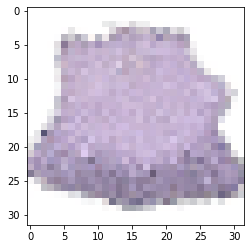

In [ ]:
#img = vnca.to_rgb(states[-1].cpu().detach())
#print(img.shape)
plt.imshow(vnca.to_rgb(states[-1].cpu().detach())[0].squeeze().permute(1,2,0).cpu().detach()) 

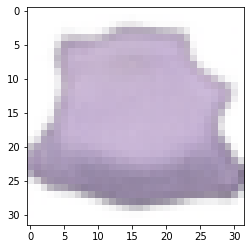

In [ ]:
plt.imshow(vnca.to_rgb(states[-1].cpu().detach())[1].squeeze().permute(1,2,0).cpu().detach()) 

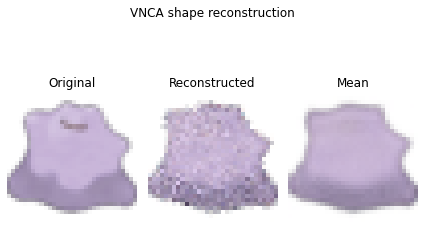

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('VNCA shape reconstruction')
ax1.imshow(dset.find("132.png")[0].permute(1, 2, 0))
ax1.axis('off')
ax1.title.set_text("Original")
ax2.imshow(vnca.to_rgb(states[-1].cpu().detach())[0].squeeze().permute(1,2,0).cpu().detach())
ax2.axis('off')
ax2.title.set_text("Reconstructed")
ax3.imshow(vnca.to_rgb(states[-1].cpu().detach())[1].squeeze().permute(1,2,0).cpu().detach())
ax3.axis('off')
ax3.title.set_text("Mean")
fig.tight_layout()

In [ ]:
samples = vnca.p_z.sample((8,)).view(8, -1, 1, 1).expand(8, -1, vnca.h, vnca.w).to(vnca.device)
states = vnca.decode(samples)
samples, samples_means = vnca.to_rgb(states[-1])

c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class 'dml.DiscretizedMixtureLogitsDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [ ]:
print(samples.shape)

torch.Size([8, 3, 32, 32])


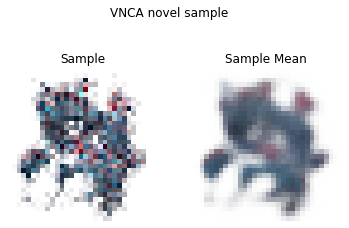

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('VNCA novel sample')
ax1.imshow(samples[0].permute(1, 2, 0).cpu().detach())
ax1.axis('off')
ax1.title.set_text("Sample")
ax2.imshow(samples_means[0].permute(1,2,0).cpu().detach())
ax2.axis('off')
ax2.title.set_text("Sample Mean")